In [39]:
#importing functions 
import numpy as np
import matplotlib.pyplot as plt
import pycce as pc 
import pandas as pd
from scipy.optimize import curve_fit 
import mpi4py

In [40]:
#define function to converge parameters
def runner(variable, values):
    print('Running:' + str(variable))
    invalue = parameters[variable]
    calc = pc.Simulator(spin=cen, bath=atoms, **parameters)
    ls = []
    
    for idx, v in enumerate(values):
        print("Progress: " + str(idx/len(values)*100) + "%")
        setattr(calc, variable, v)
        l = calc.compute(ts, method='cce',
                         nbstates=nb,
                         quantity='coherence',
                         parallel = True,)
        
        
        #print('a run done') # uncomment to see progress
        ls.append(l.real)

    parameters[variable] = invalue
    ls = pd.DataFrame(ls, columns=ts, index=values).T
    return ls

In [109]:
#import xyz file
uc = pd.read_csv('VOTPP_opt.xyz', skiprows=2, header=None, delimiter='      ', engine='python') #enter specific directory
#seperate columns into numpy arrays
N = np.array(uc[0])
x = np.array(uc[1])
y = np.array(uc[2])
z = np.array(uc[3])
#set up unit cell
sic = pc.BathCell(13.2613, 13.2613, 9.6851, 90, 90, 90, 'deg') #used optimized structure note there is also an x-ray structure with slightly different values
# z axis in cell coordinates
sic.zdir = [0, 0, 1]

#populate cell
for i in range(len(N)):
    sic.add_atoms((N[i], [x[i], y[i], z[i]]), type='angstrom')

#assign position of qubit 
# pos1 = x[76], y[76], z[76]
# pos2 = x[76], y[76], z[77]
pos1 = x[0], y[0], z[0]
pos2 = x[10], y[10], z[10]
qpos1 = sic.to_cell(pos1)
qpos2 = sic.to_cell(pos2)

#generate supercell - nuclear bath 
cell=100
atoms = sic.gen_supercell(cell, seed = 8000) #left fixed for convergence tests to avoid changes
#set          spin | gyro | quadrupole 
spin_types = [('C',  1 / 2,  6.72828),    
              ('H', 1 / 2, 26.7522),
              ('N', 1, 1.9331, 20.44 )
              #('V', 7/2, 7.05, -350)  # not added for consistency between tests
              ]   
atoms.add_type(*spin_types)


In [110]:
#set up the center 
### !!! Possible "Isotropic interaction tensor" needed here !!!
aiso = 1.4754e6
im = np.eye(3) * aiso # Isotropic interaction tensor 
cen = pc.CenterArray(position=[qpos1, qpos2], 
                     spin=[1/2, 7/2], 
                     gyro=[-17608.59705, -7.05], 
                     D=[0, -350], 
                     alpha= [0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0], beta=[0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0])


In [111]:
cen.point_dipole()

el_alpha = np.array([0,1])
el_beta = np.array([1,0])
n_alpha = np.array([0,0,0,0,0,1,0,0])
n_beta = np.array([0,0,0,0,1,0,0,0])

cen[0].alpha = el_alpha
cen[0].beta = el_beta
cen[1].alpha = n_alpha
cen[1].beta = n_beta

# Generate product state
# state = pc.normalize(np.kron(el_alpha + el_beta, n_alpha + n_beta)) # I'm kinda guessing the order here # This is performing a tensor product! (Kronecker product)
state = pc.normalize(np.kron(el_beta + el_alpha, n_beta + n_alpha)) # I'm kinda guessing the order here # This is performing a tensor product! (Kronecker product)
cen.state = state
print("Initial amplitudes in Sz x Sz basis:", np.abs(cen.state)) # Initial state
print("Interaction tensor:")
print(cen.imap[0, 1]) # in kHz

Initial amplitudes in Sz x Sz basis: [0.  0.  0.  0.  0.5 0.5 0.  0.  0.  0.  0.  0.  0.5 0.5 0.  0. ]
Interaction tensor:
[[-163269.58895493  213650.42724383  -99512.72921067]
 [ 213650.42724383   27355.80995464   64572.01537876]
 [ -99512.72921067   64572.01537876  135913.7790003 ]]


In [112]:
# Simulation parameters
nb=10
ts = np.linspace(0, 7e-2, 101) #expected T2 of 3.3e-2

#dictionary of parameters
parameters = dict(
    order=2, # CCE order
    r_bath=20,  # Size of the bath in A
    r_dipole=6,  # Cutoff of pairwise clusters in A
    pulses = 1, # N pulses in CPMG sequence
    magnetic_field=[0,0,10000] #set to 1T
) 

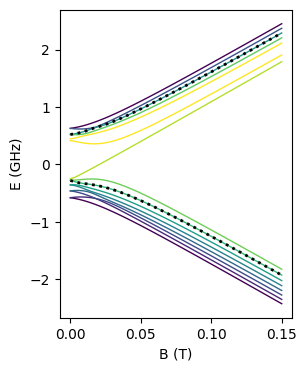

In [113]:
ens = []
ms = np.linspace(0, 1500, 51)  # applied magnetic field
for mf in ms:
    cen.generate_states([0,0, mf])
    ens.append(cen.energies)

ens = np.asarray(ens)

lowerdf = pd.DataFrame(ens[:, :10]/1e6, index=ms/1e4,
                       columns=np.arange(10))
higherdf = pd.DataFrame(ens[:, :10:-1]/1e6, index=ms/1e4,
                        columns=np.arange(11, ens.shape[1])[::-1])

fig, ax = plt.subplots(figsize=(3, 4))

lowerdf.plot(ax=ax, cmap='viridis', legend=False, lw=1)
higherdf.plot(ax=ax, cmap='viridis', legend=False, lw=1)
lowerdf[6].plot(ax=ax, color='black', ls=':', lw=2)
higherdf[13].plot(ax=ax, color='black', ls=':', lw=2)
ax.set(xlabel='B (T)', ylabel='E (GHz)', );

In [25]:
#converge for order 
orders = runner('order', [1,2,3])
orders.plot(title='convergence test for orders; cell=75; nbstates=0; [?:20:10]',
           xlabel='order', ylabel='Coherence')
plt.show()  # uncomment to show individually

Running:order
Progress: 0.0%
Progress: 33.33333333333333%


KeyboardInterrupt: 